# Example of sWeights computation

This notebook presents the **sPlot** method available in `hepstats`. This method helps to unfold the contributions of different sources, populating a data sample, for a given variable. The method is described in this [paper](https://arxiv.org/pdf/physics/0402083.pdf).

In [1]:
from scipy.stats import norm, expon
import matplotlib.pyplot as plt
import numpy as np
import os

os.environ["ZFIT_DISABLE_TF_WARNINGS"] = "1"

import zfit
from zfit.loss import ExtendedUnbinnedNLL
from zfit.minimize import Minuit

from utils import pltdist, plotfitresult 

/Users/matthieumarinangeli/zfit/zfit/util/execution.py:70: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"


In [2]:
plt.rcParams['figure.figsize'] = (9,8)
plt.rcParams['font.size'] = 16

To illustrate the method, a fake data sample of mass and momenta distributions for different species, here signal and background, are generated and plotted in the following figures.

In [3]:
bounds = (0.0, 3.0)
nbkg = 10000
nsig = 5000

# Data and signal

np.random.seed(0)
tau = -2.0
beta = -1/tau
bkg = np.random.exponential(beta, nbkg)
peak = np.random.normal(1.2, 0.2, nsig)
mass = np.concatenate((bkg, peak))

sig_p = np.random.normal(5, 1, size=nsig)
bck_p = np.random.normal(3, 1, size=nbkg)
p = np.concatenate([bck_p, sig_p])

sel = (mass > bounds[0]) & (mass < bounds[1])

mass = mass[sel]
p = p[sel]

sorter = np.argsort(mass)
mass = mass[sorter]
p = p[sorter]

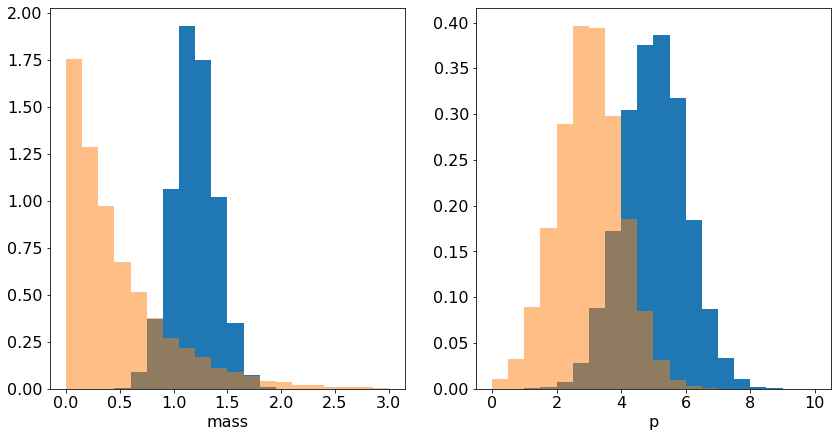

In [4]:
f, ax = plt.subplots(1, 2, figsize=(14, 7))

ax[0].hist(peak, bins=20, density=True, range=bounds)
ax[0].hist(bkg, bins=20, density=True, range=bounds, alpha=0.5)
ax[0].set_xlabel('mass')

ax[1].hist(sig_p, bins=20, density=True, range=(0, 10))
ax[1].hist(bck_p, bins=20, density=True, range=(0, 10), alpha=0.5)
ax[1].set_xlabel('p');

In the data sample the label of the species, signal and background, are not known. The data is a mixture of the two species are can be seen the next figure. In order to identify the species, a maximum likelihood (extended) fit has to be performed. 

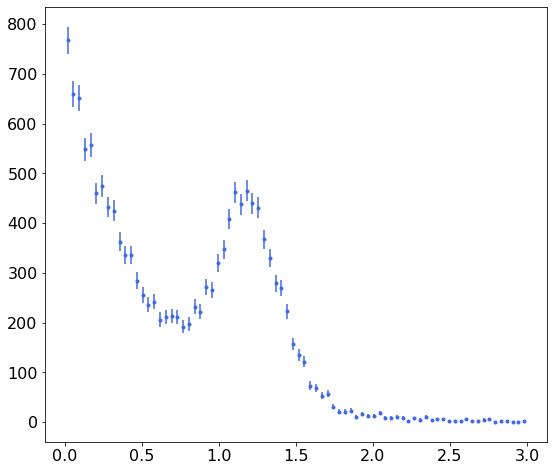

In [5]:
pltdist(mass, 80, bounds)

In this case the model to fit is a sum of a Gaussian probability density function (pdf) and an exponential pdf. The model definiton and the likelihood are defined using the `zfit` library, the minimisation of the log-likelihood function is performed with `iminuit`.

In [6]:
obs = zfit.Space('x', limits=bounds)

In [7]:
mean = zfit.Parameter("mean", 1.2, 0.5, 2.0)
sigma = zfit.Parameter("sigma", 0.3, 0.02, 0.2)
lambda_ = zfit.Parameter("lambda",-2.0, -4.0, -1.0)
Nsig = zfit.Parameter("Nsig", nsig, 0., len(mass))
Nbkg = zfit.Parameter("Nbkg", nbkg, 0., len(mass))

In [8]:
signal = zfit.pdf.Gauss(obs=obs, mu=mean, sigma=sigma).create_extended(Nsig)
background = zfit.pdf.Exponential(obs=obs, lambda_=lambda_).create_extended(Nbkg)
tot_model = zfit.pdf.SumPDF([signal, background])

In [9]:
# Create the negative log likelihood
data_ = zfit.data.Data.from_numpy(obs=obs, array=mass)
nll = ExtendedUnbinnedNLL(model=tot_model, data=data_)

/Users/matthieumarinangeli/zfit/zfit/core/loss.py:360: AdvancedFeatureWarning: Either you're using an advanced feature OR causing unwanted behavior. To turn this warning off, use `zfit.settings.advanced_warnings['extended_in_UnbinnedNLL']` = False`  or 'all' (use with care) with `zfit.settings.advanced_warnings['all'] = False
Extended PDFs are given to a normal UnbinnedNLL. This won't take the yield into account and simply treat the PDFs as non-extended PDFs. To create an extended NLL, use the `ExtendedUnbinnedNLL`.
  "extended NLL, use the `ExtendedUnbinnedNLL`.", identifier='extended_in_UnbinnedNLL')


In [10]:
# Instantiate a minuit minimizer
minimizer = Minuit()

In [11]:
# minimisation of the loss function
minimum = minimizer.minimize(loss=nll)
minimum.hesse()
print(minimum)

------------------------------------------------------------------
| FCN = -1.215E+05              |      Ncalls=67 (67 total)      |
| EDM = 0.000514 (Goal: 5E-05)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.SumPDF  params=[Composed_autoparam_1, Composed_autoparam_2] dtype=float64>0] data=[<zfit.core.data.Data object at 0x7ff9912b1e90>] constraints=[]> 
w

After the fit, the signal and background components of the data samples are plotted in the next figure. 

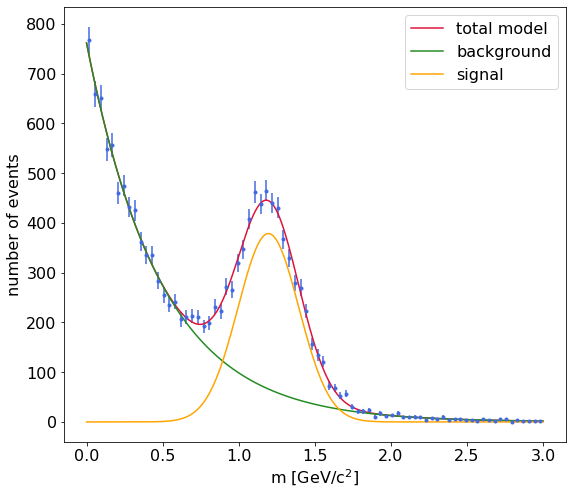

In [12]:
nbins = 80
pltdist(mass, nbins, bounds)
plotfitresult(tot_model, bounds, nbins, label="total model", color="crimson")
plotfitresult(background, bounds, nbins, label="background", color="forestgreen")
plotfitresult(signal, bounds, nbins, label="signal", color="orange")
plt.xlabel("m [GeV/c$^2$]")
plt.ylabel("number of events")
plt.legend();

As described in the [paper](https://arxiv.org/pdf/physics/0402083.pdf), after a model is fit **sWeights** can be computed from the model and the data. The `compute_sweights` function from `hepstats` is used.

In [13]:
from hepstats.splot import compute_sweights

weights = compute_sweights(tot_model, mass)

In [14]:
weights[Nsig]

array([-0.19224053, -0.19224053, -0.19224053, ..., -0.19224055,
       -0.19224055, -0.19224055])

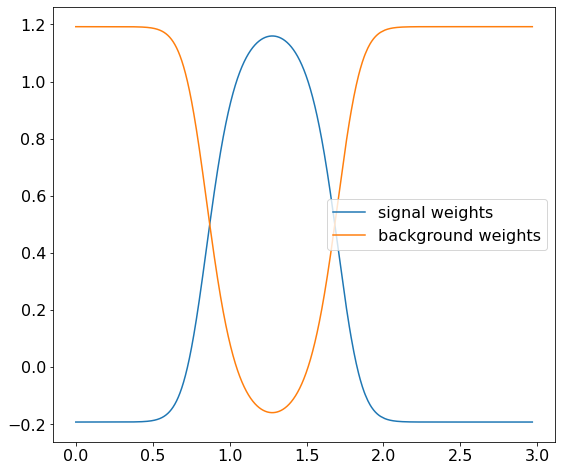

In [15]:
plt.plot(mass, weights[Nsig], label="signal weights")
plt.plot(mass, weights[Nbkg], label="background weights")
plt.legend()

The weights can be used, to unfold the signal and background components on another variable that should be stastically independent of the splotted variable, for instance here the momentum distribution.

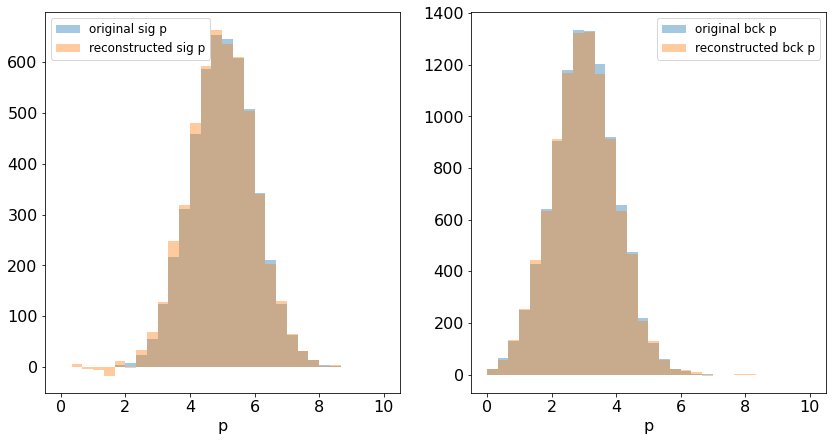

In [16]:
f, ax = plt.subplots(1, 2, figsize=(14, 7))

hist_conf = dict(bins=30, alpha=0.4, range=[0, 10])
ax[0].hist(sig_p, label='original sig p', **hist_conf)
ax[0].hist(p, weights=weights[Nsig], label='reconstructed sig p', **hist_conf)
ax[0].set_xlabel('p')
ax[0].legend(fontsize=12)

ax[1].hist(bck_p, label='original bck p', **hist_conf)
ax[1].hist(p, weights=weights[Nbkg], label='reconstructed bck p', **hist_conf)
ax[1].set_xlabel('p')
ax[1].legend(fontsize=12);

As an example of the importance of unfolding a variable distribution that is non correlated with the splotted distribution, here the sWeights are applied to the mass distribution (which is obviously correlated with the mass). 

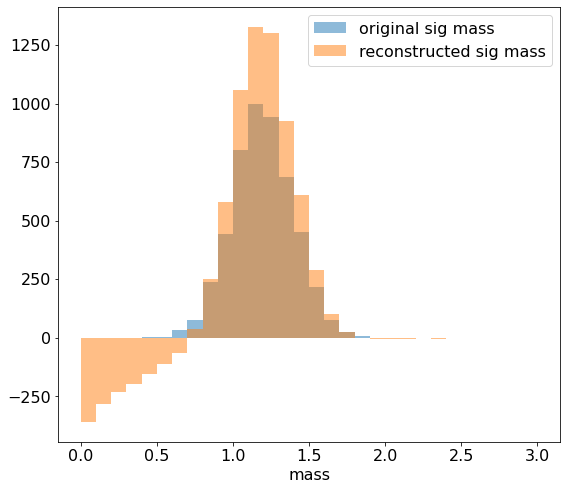

In [17]:
hist_conf = dict(bins=30, alpha=0.5, range=bounds)
plt.hist(peak, label='original sig mass', **hist_conf)
plt.hist(mass, weights=weights[Nsig], label='reconstructed sig mass', **hist_conf)
plt.xlabel('mass')
plt.legend();

In [18]:
weights

{<zfit.Parameter 'Nsig' floating=True value=5062>: array([-0.19224053, -0.19224053, -0.19224053, ..., -0.19224055,
        -0.19224055, -0.19224055]),
 <zfit.Parameter 'Nbkg' floating=True value=9912>: array([1.19205895, 1.19205895, 1.19205895, ..., 1.19205896, 1.19205896,
        1.19205896])}